<a href="https://colab.research.google.com/github/Burdin84/SciData/blob/main/Books_Recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from textwrap import wrap

import warnings
import os
warnings.filterwarnings("ignore")
%matplotlib inline

from PIL import Image
import requests



In [2]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od

In [4]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 1. Getting the data

Problem: Book recommendations - „I like Lord of the Rings, what else should I read?“ \
Goal:
- take some data, try some approaches, produce some code, get some results
- then come and show us your solution and have a chat around it - show how you think
about a specific problem, how you are able to explain what approach you used and
why, think about the limitations of the approach and how things could be improved if
there was more time, what you think of the results and if they make sense, etc.

I used database downloaded from [uni-frieburg](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)



In [5]:
od.download("https://www.kaggle.com/datasets/petrburda/books-recommendation-system")

Skipping, found downloaded files in "./books-recommendation-system" (use force=True to force download)


In [6]:
path = "/content/drive/MyDrive/Books"

In [7]:
df = pd.read_csv("/content/books-recommendation-system/BX-Books.csv", sep=';', on_bad_lines='skip', encoding='latin-1') #file has few rows in bad format, it is not comma separated but semicolomn and codding UTF8 didn't work

In [8]:
rating = pd.read_csv("/content/books-recommendation-system/BX-Book-Ratings.csv", sep=';', on_bad_lines='skip', encoding='latin-1')

In [9]:
users = pd.read_csv("/content/books-recommendation-system/BX-Users.csv", sep=';', on_bad_lines='skip', encoding='latin-1')

# 2. Simple Approach

## 2.1 EDA

### 2.1.1 BX-Books dataframe

In [10]:
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [11]:
df.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In this dataframe can be useful first 5 columns, rest of columns are links for coverpages, they can be useful for visualization, but not for recomendation, I will drop them later

### 2.1.2 BX-Book-Ratings dataframe

In [13]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [14]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [15]:
rating.notnull().count()

User-ID        1149780
ISBN           1149780
Book-Rating    1149780
dtype: int64

In [16]:
rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

This dataframe is useful and probably here I have only information which can be used for recomendation - Book-Rating

### 2.1.3 BX-Users dataframe

In [17]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


I'm not convinced Location can be relevant for recomendation, but maybe Age can be, let's find out how many information is missing

In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [19]:
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

Well, that's a lot of information missing, it's not possible to use it, so from thos dataframe I'm not going to use any information

## 2.1.4 Creating new dataframe - Books

I will merge just two dataframe books and rating, information at user dataframe are not relevant

In [20]:
books = pd.merge(rating,df, on = "ISBN", left_index=False ) 

In [21]:
books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


As I mentioned earlier, I will drop columns with links for cover pages

In [22]:
books.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis=1,inplace=True)
books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


In [23]:
books.loc[(books['Book-Title'] == "Three Weeks with My Brother") & (books["Book-Rating"] >= 9)]


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
304944,11676,0446532444,10,Three Weeks with My Brother,Micah Sparks,2004,Warner Books
304950,85993,0446532444,10,Three Weeks with My Brother,Micah Sparks,2004,Warner Books
304951,93092,0446532444,10,Three Weeks with My Brother,Micah Sparks,2004,Warner Books
304958,180942,0446532444,9,Three Weeks with My Brother,Micah Sparks,2004,Warner Books
304960,210791,0446532444,10,Three Weeks with My Brother,Micah Sparks,2004,Warner Books


In [24]:
books.loc[(books["User-ID"] == 93092) & (books["Book-Rating"] > 9)]

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
29468,93092,0060987561,10,I Know This Much Is True,Wally Lamb,1999,Regan Books
75550,93092,0064400557,10,Charlotte's Web (Trophy Newbery),E. B. White,1974,HarperTrophy
89524,93092,0553272535,10,Night,Elie Wiesel,1982,Bantam Books
96961,93092,0446532231,10,"Dude, Where's My Country?",Michael Moore,2003,Warner Books
114878,93092,0446606812,10,Message in a Bottle,Nicholas Sparks,1999,Warner Vision
133599,93092,0064400581,10,Julie of the Wolves (Julie of the Wolves),Jean Craighead George,1972,HarperTrophy
236594,93092,1558747478,10,Chicken Soup for the Parent's Soul : 101 Stori...,Mark Victor Hansen,2000,Health Communications
286065,93092,0440415829,10,Piping Down the Valleys Wild: Poetry for the Y...,Nancy Larrick,1999,Yearling Books
290232,93092,1558743316,10,A 2nd Helping of Chicken Soup for the Soul (Ch...,Jack Canfield,1994,Health Communications
304951,93092,0446532444,10,Three Weeks with My Brother,Micah Sparks,2004,Warner Books


In [25]:
books.groupby("Book-Title")["Book-Rating"].count().sort_values(ascending = False).head(50)

Book-Title
Wild Animus                                                                  2502
The Lovely Bones: A Novel                                                    1295
The Da Vinci Code                                                             898
A Painted House                                                               838
The Nanny Diaries: A Novel                                                    828
Bridget Jones's Diary                                                         815
The Secret Life of Bees                                                       774
Divine Secrets of the Ya-Ya Sisterhood: A Novel                               740
The Red Tent (Bestselling Backlist)                                           723
Angels &amp; Demons                                                           670
Life of Pi                                                                    664
Snow Falling on Cedars                                                        662
The S

In [26]:
books.groupby('Book-Title')['Book-Rating'].mean().sort_values(ascending=False).head(15)

Book-Title
Film Is: The International Free Cinema                                                                                                    10.0
More Secrets of Happy Children: Embrace Your Power as a Parent--and Help Your Children be Confident, Positive, Well-Adjusted and Happy    10.0
Jo's Boys : From the Original Publisher                                                                                                   10.0
The Vanished Priestess : An Annie Szabo Mystery                                                                                           10.0
Game and Hunting                                                                                                                          10.0
Joan Miro: 1893-1983 (Basic Series)                                                                                                       10.0
The Vampire's Apprentice                                                                                                           

We have a lot of books here, so what approach to choose?
Because I don't see much onformations I can use for filtering I will take following approach:
I love The Lord of the Rings and if someones loves it same as me and gives it rating 10 points, there is high chance that other books which were rated by 10 points by this person, can be books I like too.
This approach is not accurate, but according to the given information it's best I can figure it out

## 2.2 Functions

I will make function for filtering according to the name of the book.

First I want to have a dataframe with columns

In [27]:
""" This function returns dataframe with books rated by users which rated book I'm asking with rating above median"""

def find_books(title):

  ratings = books.loc[(books['Book-Title'] == title)]["Book-Rating"].median()
  same_rating = books.loc[(books['Book-Title'] == title) & (books["Book-Rating"] >= ratings)]
  row_count = len(books.loc[(books['Book-Title'] == title) & (books["Book-Rating"] >= ratings)])

  global same_taste
  same_taste = pd.DataFrame()

  for i in range(row_count):
    a = same_rating["User-ID"].values[i]    
    same_taste = same_taste.append(books.loc[(books["User-ID"] == a) & (books["Book-Rating"] >= ratings)])
    return same_taste

"The Lord of the Rings"

In [28]:
find_books("The Lord of the Rings")

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
144792,100578,0394820371,9,The Phantom Tollbooth,Norton Juster,1993,Yearling Books
210644,100578,0345339711,9,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey
232919,100578,0385512104,9,The Curious Incident of the Dog in the Night-T...,Mark Haddon,2003,Doubleday
543158,100578,0142301515,9,"Crown Duel (Smith, Sherwood. Crown and Court D...",Sherwood Smith,2002,Puffin Books
567816,100578,0192833693,9,The Portrait of a Lady (Oxford World's Classics),Henry James,1998,Oxford University Press
567824,100578,019283990X,9,Dombey and Son (Oxford World's Classics),Charles Dickens,2001,Oxford University Press
570021,100578,0618153969,9,The Lord of the Rings,J. R. R. Tolkien,2001,Houghton Mifflin Company
644722,100578,0192834029,10,Middlemarch (Oxford World's Classics),George Eliot,1998,Oxford University Press
714932,100578,0380977893,9,"The Ships of Air (The Fall of Ile-Rien, Book 2)",Martha Wells,2004,Eos
721014,100578,0192833553,10,Pride and Prejudice (Oxford World's Classics),Jane Austen,1998,Oxford University Press


In [29]:
same_taste.head(10)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
144792,100578,0394820371,9,The Phantom Tollbooth,Norton Juster,1993,Yearling Books
210644,100578,0345339711,9,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey
232919,100578,0385512104,9,The Curious Incident of the Dog in the Night-T...,Mark Haddon,2003,Doubleday
543158,100578,0142301515,9,"Crown Duel (Smith, Sherwood. Crown and Court D...",Sherwood Smith,2002,Puffin Books
567816,100578,0192833693,9,The Portrait of a Lady (Oxford World's Classics),Henry James,1998,Oxford University Press
567824,100578,019283990X,9,Dombey and Son (Oxford World's Classics),Charles Dickens,2001,Oxford University Press
570021,100578,0618153969,9,The Lord of the Rings,J. R. R. Tolkien,2001,Houghton Mifflin Company
644722,100578,0192834029,10,Middlemarch (Oxford World's Classics),George Eliot,1998,Oxford University Press
714932,100578,0380977893,9,"The Ships of Air (The Fall of Ile-Rien, Book 2)",Martha Wells,2004,Eos
721014,100578,0192833553,10,Pride and Prejudice (Oxford World's Classics),Jane Austen,1998,Oxford University Press


In [30]:
recomend = same_taste.sample(5)
recomend

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
144792,100578,0394820371,9,The Phantom Tollbooth,Norton Juster,1993,Yearling Books
866806,100578,0192835211,9,Catharine and Other Writings (Oxford World's C...,Jane Austen,1998,Oxford University Press
570021,100578,0618153969,9,The Lord of the Rings,J. R. R. Tolkien,2001,Houghton Mifflin Company
567816,100578,0192833693,9,The Portrait of a Lady (Oxford World's Classics),Henry James,1998,Oxford University Press
714932,100578,0380977893,9,"The Ships of Air (The Fall of Ile-Rien, Book 2)",Martha Wells,2004,Eos


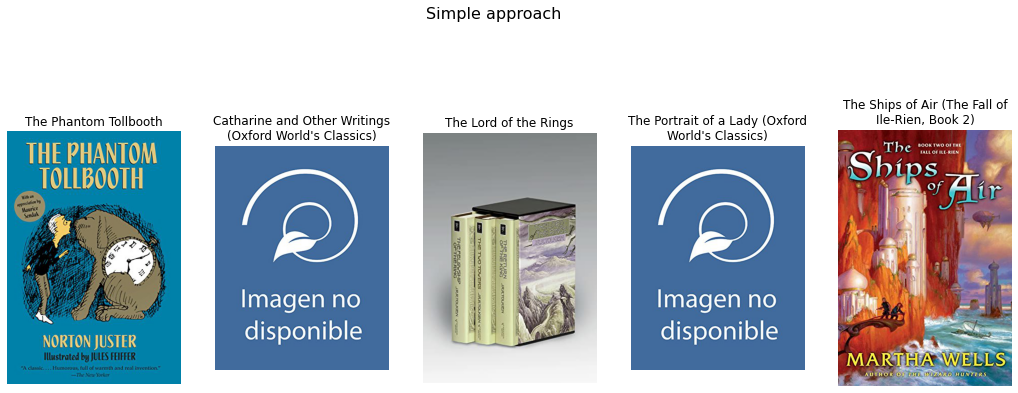

In [31]:
"""This function plots picture of recommended books"""

fig, ax = plt.subplots(1, 5,figsize=(18,5))

for i in range(len(recomend["Book-Title"].tolist())):
        
  url = df.loc[df["Book-Title"] == recomend["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
  image = Image.open(requests.get(url, stream=True).raw)
  ax[i].imshow(image)
  ax[i].axis("off")
  ax[i].set_title("\n".join(wrap("{}".format(recomend["Book-Title"].iloc[i]), 30)))
  fig.suptitle("Simple approach", fontsize = 16, y = 1.2)
  fig.show()

In [32]:
found = books[books["Book-Title"].str.contains("The Lord of the Rings")]
found.count()

User-ID                1335
ISBN                   1335
Book-Rating            1335
Book-Title             1335
Book-Author            1335
Year-Of-Publication    1335
Publisher              1335
dtype: int64

In [33]:
found = books['Book-Title'][books["Book-Title"].isin(["The Lord of the Rings"])]
found.count()

38

In [34]:
#wrap_labels(ax, 10)
#ax.figure

In [35]:
"""This is combination of fumctions above, it returns recommended books for asked book and plot pictures of recommended books"""

def recomend_books(title):
  found = books['Book-Title'][books["Book-Title"].isin([title])] #checking if name of the book is in the dataset

  if found.count() > 1:

    def find_books(title):

      ratings = books.loc[(books['Book-Title'] == title)]["Book-Rating"].median()
      same_rating = books.loc[(books['Book-Title'] == title) & (books["Book-Rating"] >= ratings)]
      row_count = len(books.loc[(books['Book-Title'] == title) & (books["Book-Rating"] >= ratings)])

      global same_taste
      same_taste = pd.DataFrame()

      for i in range(row_count):
        a = same_rating["User-ID"].values[i]    
        same_taste = same_taste.append(books.loc[(books["User-ID"] == a) & (books["Book-Rating"] >= ratings)])
        return same_taste
    recomend = same_taste.sample(5)

    fig, ax = plt.subplots(1, 5,figsize=(18,5))

    for i in range(len(recomend["Book-Title"].tolist())):
        
      url = df.loc[df["Book-Title"] == recomend["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
      im = Image.open(requests.get(url, stream=True).raw)
      ax[i].imshow(im)
      ax[i].axis("off")
      ax[i].set_title("\n".join(wrap("{}".format(recomend["Book-Title"].iloc[i]), 30)))
      #ax[i].plt.title("{}".format(recomend["Book-Title"].iloc[i]), y=1.1 ,fontsize=12, rotation = 0, wrap = True)
      #ax[i].set_title('Rating: {}'.format(round(books.loc[(books['Book-Title'] == title)]["Book-Rating"].median(),1)),y=-0.18)
      fig.suptitle("Simple approach", fontsize = 16, y = 1.2)
      fig.show()

  else:
    print("This book is not in dataset")

## 2.3 Result

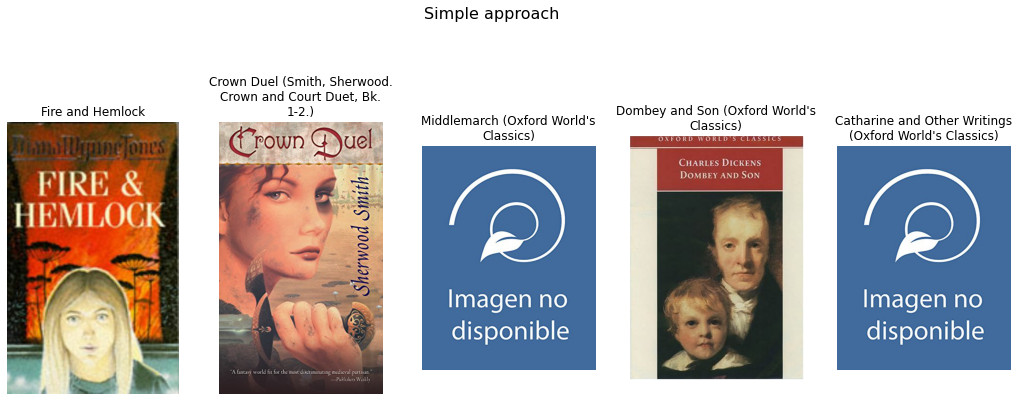

In [36]:
recomend_books("The Lord of the Rings")

# 3. Collaborative filtering

The recommendations are done based on the user’s behavior. History of the user plays an important role. For example, if the user ‘A’ likes ‘Coldplay’, ‘The Linkin Park’ and ‘Britney Spears’ while the user ‘B’ likes ‘Coldplay’, ‘The Linkin Park’ and ‘Taylor Swift’ then they have similar interests. So, there is a huge probability that the user ‘A’ would like ‘Taylor Swift’ and the user ‘B’ would like ‘Britney Spears’. This is the way collaborative filtering is done. 

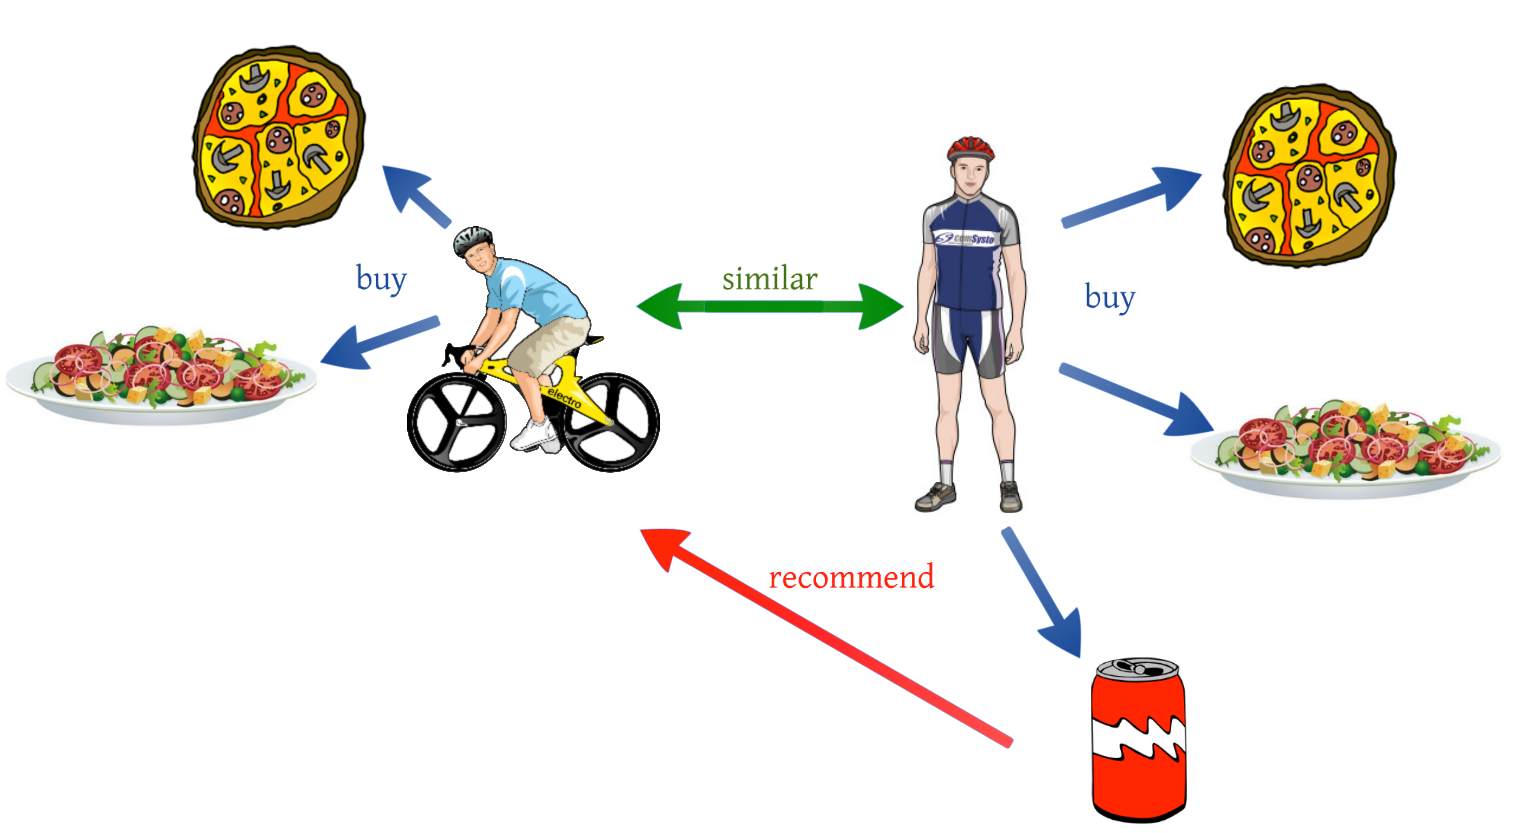
**source** [Towardsdatascience](https://towardsdatascience.com/brief-on-recommender-systems-b86a1068a4dd)

## 3.0 Libraries

In [37]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


## 3.1 Dataset preparation

Let's look on the data again with new perspective

In [38]:
dfbooks = df
dfbooks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [39]:
dfbooks.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Just few info is missing, in my opinion I can write there "unknown"

In [40]:
dfbooks.fillna("unknown", inplace = True)

In [41]:
df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [42]:
dfrating = rating


In [43]:
dfrating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [44]:
dfrating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [45]:
dfusers = users
dfusers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [46]:
dfusers.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

## 3.2 EDA

In [47]:
round(dfusers.isnull().sum() / len(dfusers) * 100, 4)

User-ID      0.0000
Location     0.0000
Age         39.7199
dtype: float64

Well, almost 40% is pretty a lot of information missing, should I drop it or not... \


In [48]:
dfusers["Age"].value_counts()

24.0     5687
25.0     5618
26.0     5547
23.0     5456
27.0     5383
         ... 
168.0       1
132.0       1
159.0       1
186.0       1
127.0       1
Name: Age, Length: 165, dtype: int64

Also, here are a lot of outlayers, I should take care of them

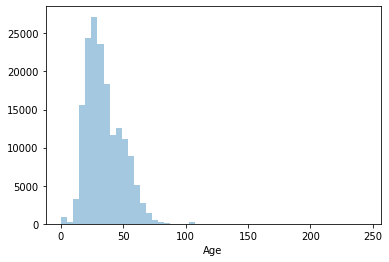

In [49]:
sns.distplot(dfusers["Age"], kde = False)

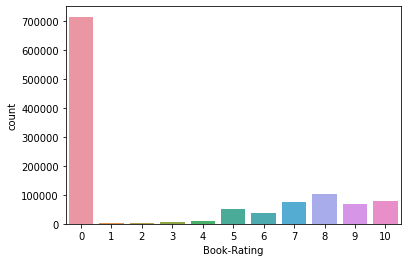

In [50]:
sns.countplot(x = "Book-Rating", data = dfrating)

Rating equals to 0 is probably more "not rated" than "bad book", I'll change it to "None"

In [51]:
dfrating["Book-Rating"] = dfrating["Book-Rating"].replace(0, None)

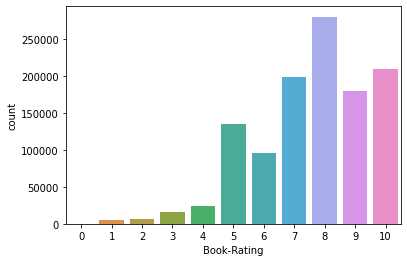

In [52]:
sns.countplot(x = "Book-Rating", data = dfrating)

So, if I zero values were changed to None, what is average rating of books?

In [53]:
print(round(dfrating["Book-Rating"].mean(), 2))

7.61


Another information which can be usefull is country contained in Location

In [54]:
country = dfusers["Location"].apply(lambda row: str(row).split(",")[-1])

In [55]:
round(country.value_counts("usa").head(7).sum(), 2)

0.84

We can see Top 7 Countries are 84% of whole dataset

In [56]:
country.value_counts()

 usa                139711
 canada              21658
 united kingdom      18538
 germany             17043
 spain               13147
                     ...  
 19104                   1
 minnehaha               1
 de                      1
 china öð¹ú              1
 united kingdom.         1
Name: Location, Length: 709, dtype: int64

In [57]:
country.value_counts().head(25)

 usa               139711
 canada             21658
 united kingdom     18538
 germany            17043
 spain              13147
 australia          11784
 italy              11266
                     4578
 france              3455
 portugal            3325
 new zealand         3097
 netherlands         3025
 switzerland         1745
 brazil              1674
 china               1488
 sweden              1406
 india               1290
 austria             1136
 malaysia            1119
 argentina           1083
 singapore            925
 finland              923
 mexico               840
 belgium              819
 denmark              805
Name: Location, dtype: int64

Obviously most of users are from US, some users don't have country filled

In [58]:
country.describe()

count     278858
unique       709
top          usa
freq      139711
Name: Location, dtype: object

## 3.3 Feature engineering

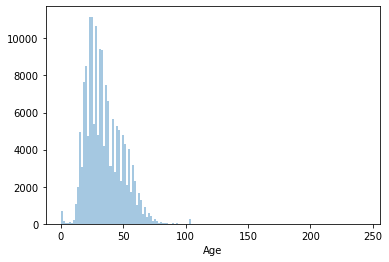

In [59]:
sns.distplot(dfusers["Age"], bins = 150, kde = False)

In [60]:
dfusers["Age"] = np.where(dfusers["Age"]>90, None, dfusers["Age"])

In [61]:
print( sum(dfusers["Age"] > 90))

0


In [62]:
median = dfusers["Age"].median()    #Median of age of all users
std = dfusers["Age"].std()          #Standard deviation
is_null = dfusers["Age"].isnull().sum() #How many users doesn't have age filled
rand_age = np.random.randint(median - std, median + std, size = is_null) #returns random numbers (integers) from low to high, with size of NA values for approppriate distribution
age_slice = dfusers["Age"].copy()
age_slice[pd.isnull(age_slice)] = rand_age # null values filled by random age
dfusers["Age"] = age_slice  
dfusers["Age"] = dfusers["Age"].astype(int)

In [63]:
print( sum(dfusers["Age"] > 90))

0


In [64]:
dfusers["Age"].isnull().sum()

0

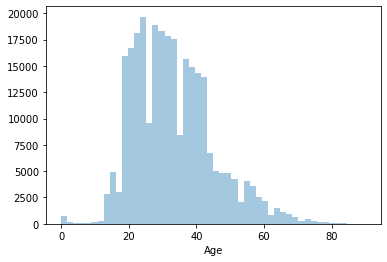

In [65]:
sns.distplot(dfusers["Age"], kde = False)

This age distribution looks similar to the original one, I will keep it like this

In [66]:
dfusers['Country'] = dfusers['Location'].apply(lambda row: str(row).split(',')[-1])

Because I have Country, I will drop Location column

In [67]:
dfusers = dfusers.drop("Location", axis = 1)

In [68]:
dfusers.head()

,User-ID,Age,Country
0,1,42,usa
1,2,18,usa
2,3,39,russia
3,4,17,portugal
4,5,34,united kingdom


Because 84% of dataset makes users from 7 countries, I will change rest to "others"

In [69]:
dfusers['Country'][~dfusers["Country"].isin([" usa", " canada", " united kingdom", " germany", " spain", " australia", " italy"])] = "others"

(-1.0, 8.0)

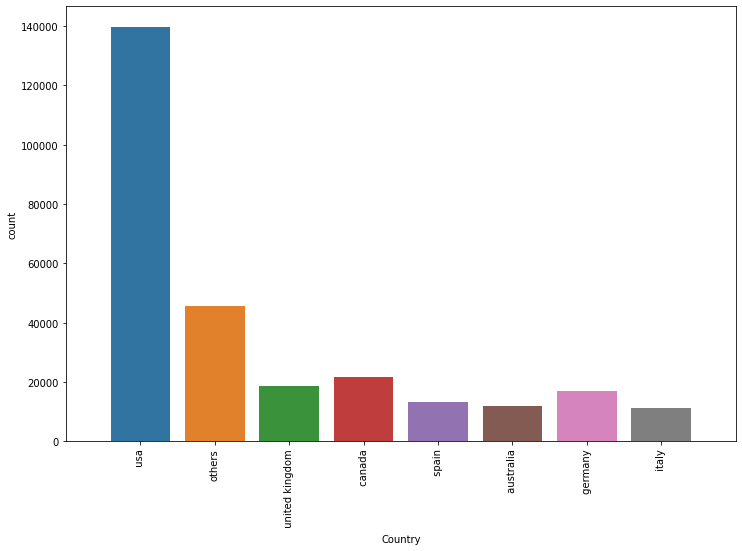

In [70]:
plt.figure(figsize = (12,8))
sns.countplot(x = "Country", data = dfusers) 
plt.xticks(rotation=90)
#plt.ylim(0, 24000)
plt.xlim(-1,8)

In [71]:
dfusers.head()

,User-ID,Age,Country
0,1,42,usa
1,2,18,usa
2,3,39,others
3,4,17,others
4,5,34,united kingdom


Now I should have most of the informations changed to more suitable values, it´s time to merge all dataframes together 

## 3.4 Preparing dataset

In [72]:
data = pd.merge(dfusers, dfrating, on = "User-ID", how = "inner")

In [73]:
data = pd.merge(data, dfbooks, on = "ISBN", how = "inner")

In [74]:
data.head()

,User-ID,Age,Country,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,18,usa,0195153448,8,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,8,31,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,11400,49,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,11676,22,others,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
4,41385,39,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


Now I will drop Image columns

In [75]:
data.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis=1,inplace=True)
data.head()

,User-ID,Age,Country,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,2,18,usa,0195153448,8,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,8,31,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,11400,49,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,11676,22,others,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
4,41385,39,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada


In [76]:
data.shape

(1031136, 9)

In [77]:
round(data.isnull().sum() / len(data) * 100, 4)

User-ID                0.0
Age                    0.0
Country                0.0
ISBN                   0.0
Book-Rating            0.0
Book-Title             0.0
Book-Author            0.0
Year-Of-Publication    0.0
Publisher              0.0
dtype: float64

In [78]:
popular_books = data.groupby('Book-Title').agg(['count', 'mean'])['Book-Rating'].reset_index()

In [79]:
popular_books.head()

,Book-Title,count,mean
0,A Light in the Storm: The Civil War Diary of ...,4,8.25
1,Always Have Popsicles,1,9.00
2,Apple Magic (The Collector's series),1,8.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.00
4,Beyond IBM: Leadership Marketing and Finance ...,1,10.00


In [80]:
rating_books = data.groupby(['User-ID','Book-Title', 'Publisher']).agg(["count"])['Book-Rating'].reset_index()

In [81]:
rating_books.head(10)

,User-ID,Book-Title,Publisher,count
0,2,Classical Mythology,Oxford University Press,1
1,8,A Second Chicken Soup for the Woman's Soul (Ch...,Health Communications,1
2,8,Clara Callan,HarperFlamingo Canada,1
3,8,Decision in Normandy,HarperPerennial,1
4,8,Flu: The Story of the Great Influenza Pandemic...,Farrar Straus Giroux,1
5,8,Goodbye to the Buttermilk Sky,River City Pub,1
6,8,Hitler's Secret Bankers: The Myth of Swiss Neu...,Citadel Press,1
7,8,Jane Doe,Mira Books,1
8,8,More Cunning Than Man: A Social History of Rat...,Kensington Publishing Corp.,1
9,8,Nights Below Station Street,Emblem Editions,1


In [82]:
data.iloc[0:20]

,User-ID,Age,Country,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,2,18,usa,0195153448,8,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,8,31,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,11400,49,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,11676,22,others,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
4,41385,39,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
5,67544,30,canada,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
6,85526,36,canada,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
7,96054,29,canada,0002005018,7,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
8,116866,26,others,0002005018,9,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
9,123629,41,canada,0002005018,9,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada


In [83]:
number_rating = data.groupby('Book-Title')['Book-Rating'].count().reset_index()   #I want to know how many times each book was rated
number_rating.rename(columns= {'Book-Rating':'number_of_ratings'}, inplace=True) #here I'm renaming column "Book-Rating" to "number_of_ratings"
final_rating = data.merge(number_rating, on='Book-Title')                         #final rating is done by merging original dataset with modified one
final_rating = final_rating[final_rating['number_of_ratings'] >= 20]              #it's probably better to not consider books with less then 20 ratings from users
final_rating.drop_duplicates(['User-ID','Book-Title'], inplace=True)              #because lot of people read same books, there are lot of duplicities in dataset, by this I leave unique names
final_rating

,User-ID,Age,Country,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,number_of_ratings
31,8,31,canada,0399135782,5,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,311
32,11676,22,others,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,311
33,29526,26,usa,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,311
34,36836,56,usa,0399135782,10,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,311
35,46398,37,usa,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,311
...,...,...,...,...,...,...,...,...,...,...
818139,234359,35,usa,1551667118,5,On The Edge: 3 Novels in 1,Heather Graham,2003,Mira,21
818140,242824,21,usa,1551667118,10,On The Edge: 3 Novels in 1,Heather Graham,2003,Mira,21
818141,249723,32,usa,1551667118,8,On The Edge: 3 Novels in 1,Heather Graham,2003,Mira,21
818142,250015,31,others,1551667118,10,On The Edge: 3 Novels in 1,Heather Graham,2003,Mira,21


## 3.5 Model creation

In [84]:
book_pivot = final_rating.pivot_table(columns='User-ID', index='Book-Title', values="Book-Rating")
book_pivot.fillna(0, inplace=True)

In [85]:
book_name = "Zoya"

In [86]:
book_id=np.where(book_pivot.index== book_name)[0][0]

In [87]:
book_id

7598

In [88]:
book_pivot.shape

(7608, 60046)

In [89]:
book_pivot

User-ID,8,9,10,14,16,17,19,23,26,32,...,278832,278836,278838,278843,278844,278846,278849,278851,278852,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01-01-00: The Novel of the Millennium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001 Ways to Be Romantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iI Paradiso Degli Orchi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
book_sparse = csr_matrix(book_pivot)
book_sparse

<7608x60046 sparse matrix of type '<class 'numpy.float64'>'
	with 438232 stored elements in Compressed Sparse Row format>

In [91]:

model=NearestNeighbors(n_neighbors = 6, algorithm='brute') ## model

In [92]:
model.fit(book_sparse)

NearestNeighbors(algorithm='brute', n_neighbors=6)

In [93]:
#book_pivot.iloc[a,:].values.reshape(1,-1)

In [94]:
distances,suggestions=model.kneighbors(book_pivot.iloc[3,:].values.reshape(1,-1))

In [95]:
distances

array([[ 0.        , 46.33573135, 46.43274706, 46.57252409, 46.86149806,
        46.9041576 ]])

In [96]:
suggestions ## recommendation

array([[   3, 1086, 1148, 5018, 4494, 1953]])

In [97]:
for i in range(len(suggestions)):
    print(book_pivot.index[suggestions[i]])

Index(['1001 Ways to Be Romantic',
       'Chains of Command (Star Trek The Next Generation, No 21)',
       'Chobits (Chobits)', 'Spyder Web',
       'Rogue Squadron (Star Wars: X-Wing Series, Book 1)',
       'False Prophet: A Peter Decker/Rina Lazarus Novel (Peter Decker &amp; Rina Lazarus Novels (Paperback))'],
      dtype='object', name='Book-Title')


## 3.6 Recommendation function

In [98]:
"""This function as first thing checks if book is in dataset, then runs a modelwhich suggests books and it plots out picture of recommended books"""

def recommend_book2(title):

  found = dfbooks['Book-Title'][dfbooks["Book-Title"].isin([title])]

  if found.count() > 1:

    book_index=np.where(book_pivot.index==title)[0][0]
    distances,suggestions=model.kneighbors(book_pivot.iloc[book_index,:].values.reshape(1,-1))
    
     
    for i in range(len(suggestions)):
      if i==0:
        print("the suggestions for ",title,"are : ")
      #if not i:
        #print(book_pivot.index[suggestions[i]])

    titles = suggestions[0].tolist()
    
    fig, ax = plt.subplots(1, 6,figsize=(18,5))

    for i in range(len(titles)):
        
      url = df.loc[dfbooks["Book-Title"] == book_pivot.index[titles[i]],"Image-URL-L"][:1].values[0]
      im = Image.open(requests.get(url, stream=True).raw)
      ax[i].imshow(im)
      ax[i].axis("off")
      ax[i].set_title("\n".join(wrap("{}".format(book_pivot.index[titles[i]]), 30)))

      fig.suptitle("Collaborative filtering", fontsize = 16, y = 1)
      fig.show()

  else:
    print("This book is not in dataset")

the suggestions for  The Lord of the Rings are : 


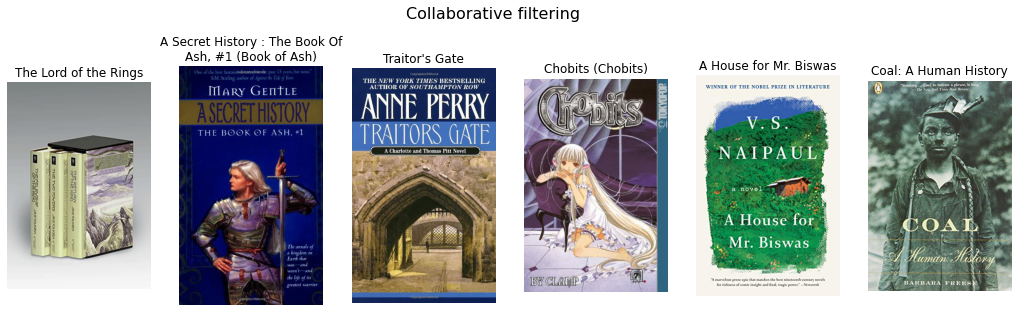

In [99]:
recommend_book2("The Lord of the Rings")

In [100]:
def recommendation (title):

  recomend_books(title)

  recommend_book2(title)

# 4. Final result

the suggestions for  The Lord of the Rings are : 


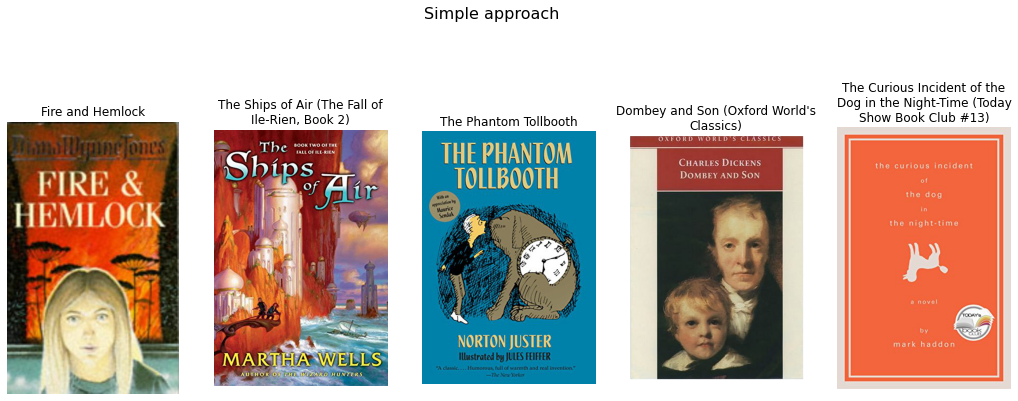

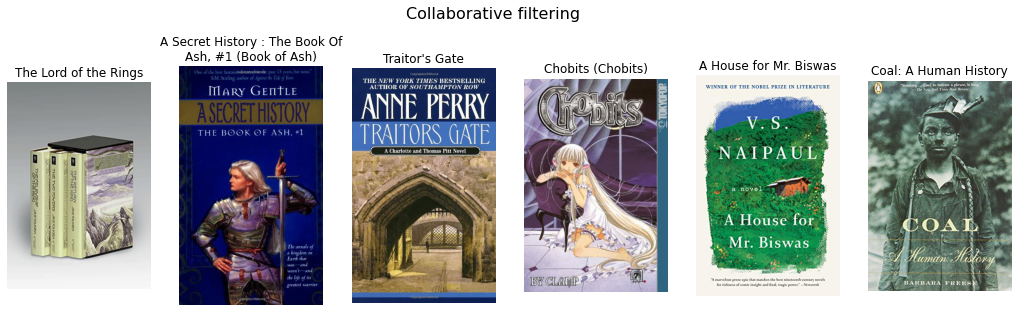

In [101]:
recommendation("The Lord of the Rings")